# Brain Tumor Detection Using CNN

### AWS Machine Learning Engineer Nanodegree Capstone Project

### Project Overview

Advancement in technology has resulted in the generation of a prodigious amount of data from everywhere. Due to the increasing amounts of electronic data in the healthcare, life sciences, and bioscience industry, medical doctors and physicians are facing problems in analyzing the data using traditional diagnosing systems. Nevertheless, machine learning and deep learning techniques have aided doctors and experts in detecting deadly diseases in their early stages.

A brain tumor is the growth of abnormal cells in the brain tissues. It can be cancerous and non-cancerous. The brain tumor is the most dangerous disease and can be diagnosed efficiently and reliably with the help of technology. We can use automated techniques on MRI Images for accurate detection of brain tumors. The brain is one of the most complicated organs inside the human body. It works with a plethora of cells. Myriads of approaches for the efficient diagnosis of brain tumors have been proposed by numerous practitioners and researchers for adequate tumor detection. 

The aim of this project is to build a Brain Tumor detection model using a Convolutional Neural Network using the Brain MRI Images Dataset.

## Data Preparation

In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import time    
from os import listdir
import imutils
from sklearn.utils import shuffle

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

Found GPU at: /device:GPU:0
2.8.2


## Dataset

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 73% 11.0M/15.1M [00:00<00:00, 16.9MB/s]
100% 15.1M/15.1M [00:00<00:00, 19.5MB/s]


In [4]:
import zipfile

z= zipfile.ZipFile('brain-mri-images-for-brain-tumor-detection.zip')
z.extractall()

In [5]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for file_name in os.listdir(folder):
    source = folder + file_name
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print('All files are renamed in the "yes" directory')

All files are renamed in the "yes" directory


In [6]:
folder = 'brain_tumor_dataset/no/'
count = 1

for file_name in os.listdir(folder):
    source = folder + file_name
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print('All files are renamed in the "no" directory')

All files are renamed in the "no" directory


## Exploratory Data Analysis

In [7]:
list = os.listdir('brain_tumor_dataset/yes/')
number_files_yes = len(list)
print (number_files_yes)

list = os.listdir('brain_tumor_dataset/no/')
number_files_no = len(list)
print (number_files_no)

155
98


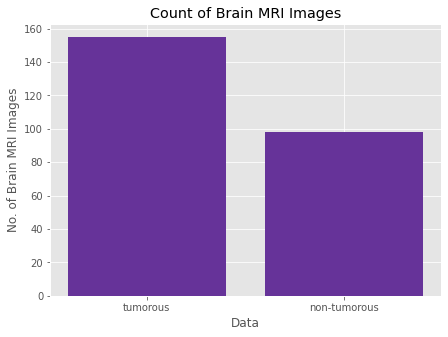

In [9]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}
typex = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (7, 5))
 
plt.bar(typex, values, color = 'rebeccapurple')
 
plt.xlabel("Data")
plt.ylabel("No. of Brain MRI Images")
plt.title("Count of Brain MRI Images")
plt.savefig("outputs/count_brain_mri_images.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

## Data Augmentation

Since the number of images in the dataset is less, we will perform data augmentation. It is a set of techniques to artificially expand the amount of data by spawning new data points from existing data. It includes making minor modifications to data or using deep learning methods to render new data points. 

Moreover, data augmentation can also solve the data imbalance issue. In our case, 61% (155 images) belong to the tumorous class, and 39% (98 images) belong to the non-tumorous class, creating a data imbalance. So, to solve the data imbalance issue, we will generate nine new images for every image belonging to the "no" class, and six images for every image belonging to the "yes" class.

In [10]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [11]:
def augment_data(file_dir, n_generated_samples, save_to_dir):

    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [12]:
start_time = time.time()

yes_path = "brain_tumor_dataset/yes"
no_path = "brain_tumor_dataset/no"

augmented_data_path = 'augmented_data/'

augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:1:37.8


In [15]:
# shutil.rmtree('augmented_data/.ipynb_checkpoints/')
# shutil.rmtree('augmented_data/yes/.ipynb_checkpoints/')
# shutil.rmtree('augmented_data/no/.ipynb_checkpoints/')

In [16]:
def data_summary(main_path):
    
    yes_path = 'augmented_data/yes/'
    no_path = 'augmented_data/no/'
        
    m_pos = len(listdir(yes_path))
    m_neg = len(listdir(no_path))
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, Number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, Number of neg examples: {m_neg}") 

In [17]:
data_summary(augmented_data_path)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, Number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, Number of neg examples: 980


In [18]:
list = os.listdir('augmented_data/yes')
number_files_yes = len(list)
print (number_files_yes)

list = os.listdir('augmented_data/no')
number_files_no = len(list)
print (number_files_no)

1085
980


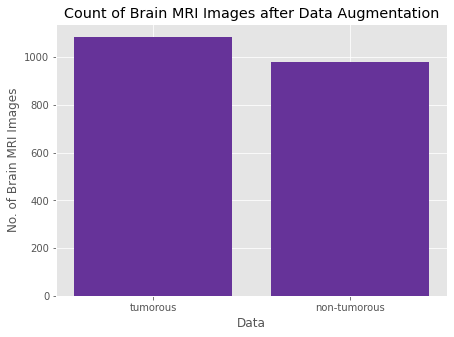

In [21]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}
typex = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (7, 5))
 
plt.bar(typex, values, color = 'rebeccapurple')
 
plt.xlabel("Data")
plt.ylabel("No. of Brain MRI Images")
plt.title("Count of Brain MRI Images after Data Augmentation")
plt.savefig("outputs/count_brain_mri_images2.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

## Data Preprocessing

### Image Cropping

In [22]:
def crop_brain_contour(image, plot=False):
   
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

#### Image Cropping Examples

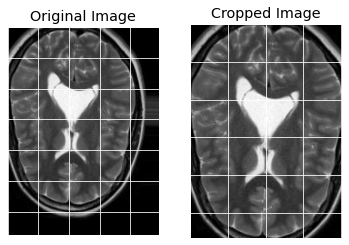

In [25]:
ex_img = cv2.imread('augmented_data/yes/aug_Y_100_0_8403.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

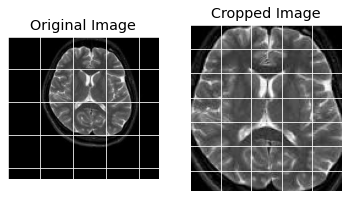

In [24]:
ex_img = cv2.imread('augmented_data/no/aug_N_10_0_6658.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

#### Updating the image files after cropping

In [26]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for file_name in os.listdir(folder1):
    img = cv2.imread(folder1 + file_name)
    img = crop_brain_contour(img, False)
    cv2.imwrite(folder1 + file_name, img)

for file_name in os.listdir(folder2):
    img = cv2.imread(folder2 + file_name)
    img = crop_brain_contour(img, False)
    cv2.imwrite(folder2 + file_name, img)

print('All files are updated')

All files are updated


### Image Loading

In [28]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), 
                               interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y    

In [29]:
augmented_path = 'augmented_data/'

augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


### Sample Image Plotting

In [30]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

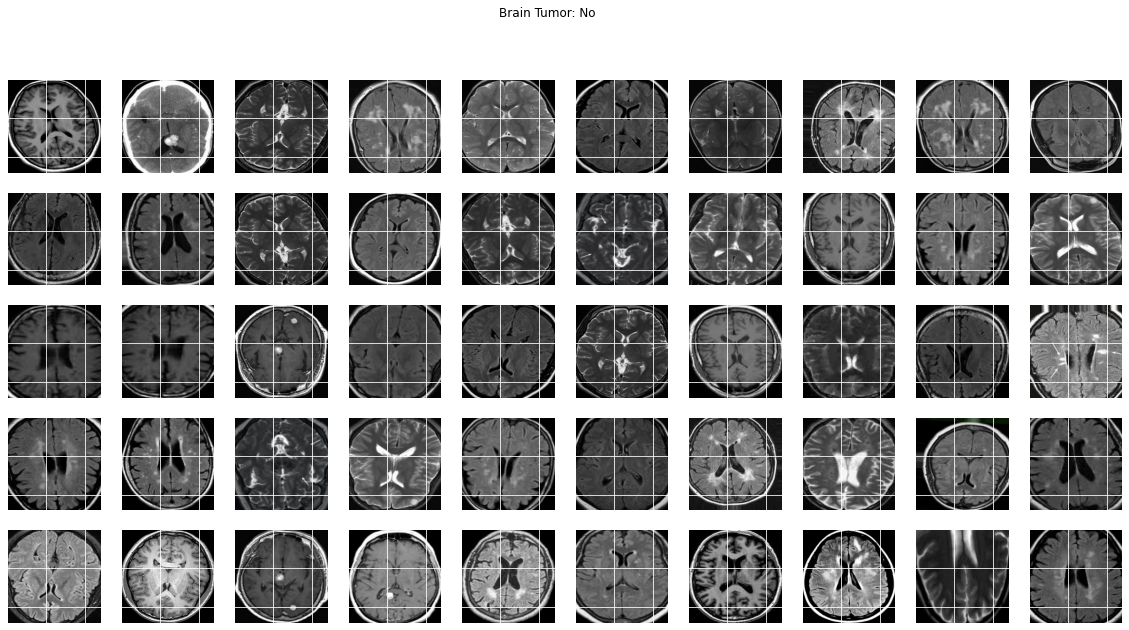

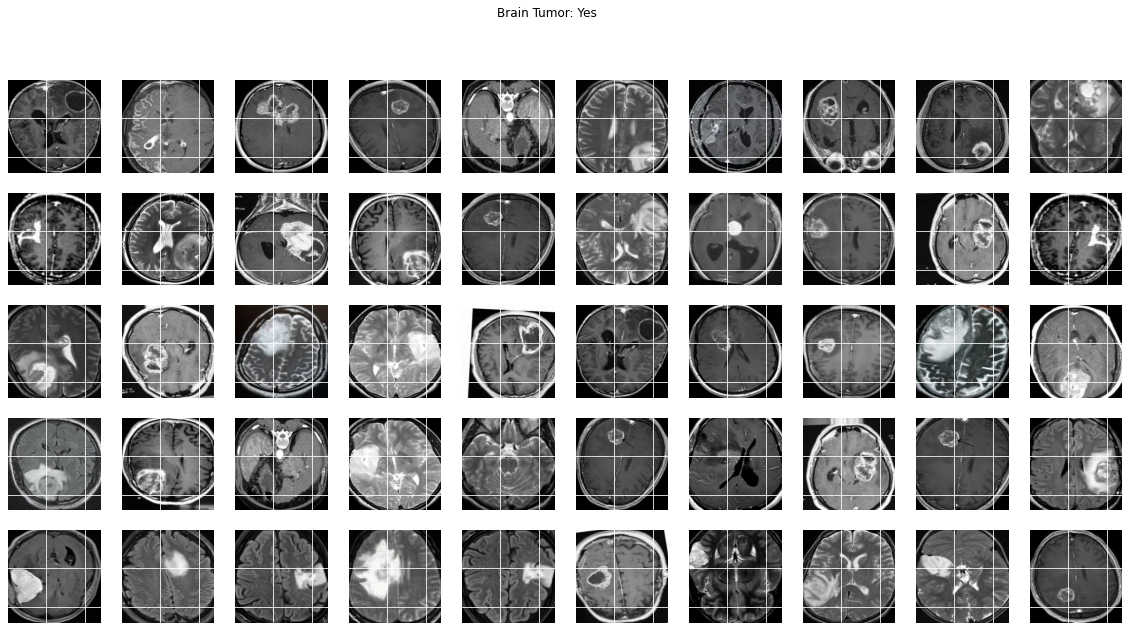

In [31]:
plot_sample_images(X, y)

## Data Splitting

In [32]:
# Create a base dir
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [33]:
# Make train, valid and test directories
#train
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
#valid
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir, 'valid')
    os.mkdir(valid_dir)
#test
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

In [34]:
# Make directories for infected images in each of the train, valid and test directories
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_trn_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_trn_dir)

if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)

In [35]:
# Make directories for healthy images in each of the train, valid and test directories
if not os.path.isdir('tumorous_and_nontumorous/train/non-tumorous'):
    healthy_trn_dir = os.path.join(train_dir, 'non-tumorous')
    os.mkdir(healthy_trn_dir)

if not os.path.isdir('tumorous_and_nontumorous/valid/non-tumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'non-tumorous')
    os.mkdir(healthy_valid_dir)

if not os.path.isdir('tumorous_and_nontumorous/test/non-tumorous'):
    healthy_test_dir = os.path.join(test_dir, 'non-tumorous')
    os.mkdir(healthy_test_dir)

In [36]:
list = os.listdir('augmented_data/yes/')
number_files = len(list)
print (number_files)

1085


In [37]:
list = os.listdir('augmented_data/no/')
number_files = len(list)
print (number_files)

980


In [38]:
original_dataset_tumorous = os.path.join('augmented_data', 'yes/')
original_dataset_nontumorous = os.path.join('augmented_data', 'no/')

In [39]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0, 759):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_trn_dir, fname)
    shutil.copyfile(src, dst)

In [40]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759, 922):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src,dst)

In [41]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922, 1085):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_tumorous, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src,dst)

In [42]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0, 686):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_trn_dir, fname)
    shutil.copyfile(src,dst)

In [43]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686, 833):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src,dst)

In [44]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833, 980):
    fnames.append(files[i])
    
for fname in fnames:
    src = os.path.join(original_dataset_nontumorous, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src,dst)

In [45]:
print("{} Tumorous training images".format(len(os.listdir(infected_trn_dir))))
print("{} Non - Tumorous training images".format(len(os.listdir(healthy_trn_dir))))
print(" {} Tumorous valid images".format(len(os.listdir(infected_valid_dir))))
print(" {} Non - Tumorous valid images".format(len(os.listdir(healthy_valid_dir))))
print(" {} Tumorous testing images".format(len(os.listdir(infected_test_dir))))
print(" {} Non - Tumorous testing images".format(len(os.listdir(healthy_test_dir))))

759 Tumorous training images
686 Non - Tumorous training images
 163 Tumorous valid images
 147 Non - Tumorous valid images
 163 Tumorous testing images
 147 Non - Tumorous testing images


In [46]:
# Train
infected_trn_fpaths = [os.path.join(infected_trn_dir, fpath) for 
                       fpath in os.listdir(infected_trn_dir)]

healthy_trn_fpaths = [os.path.join(healthy_trn_dir, fpath) for 
                      fpath in os.listdir(healthy_trn_dir)]

# Valid
infected_valid_fpaths = [os.path.join(infected_valid_dir, fpath) for 
                         fpath in os.listdir(infected_valid_dir)]

healthy_valid_fpaths = [os.path.join(healthy_valid_dir, fpath) for 
                        fpath in os.listdir(healthy_valid_dir)]

# Test
infected_test_fpaths = [os.path.join(infected_test_dir, fpath) for 
                        fpath in os.listdir(infected_test_dir)]
                        
healthy_test_fpaths = [os.path.join(healthy_test_dir, fpath) for 
                       fpath in os.listdir(healthy_test_dir)]

In [47]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

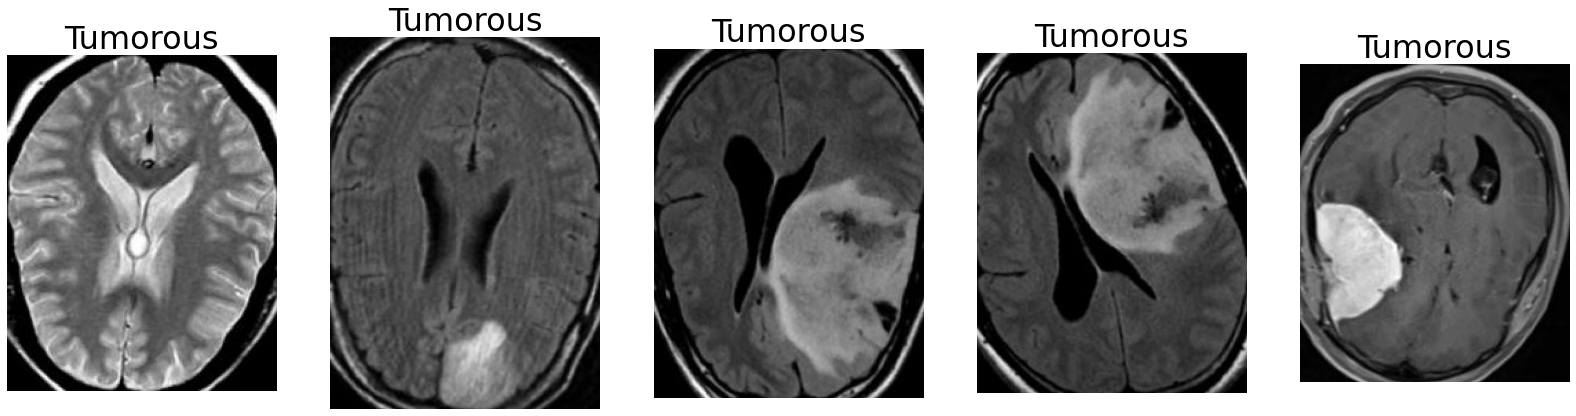

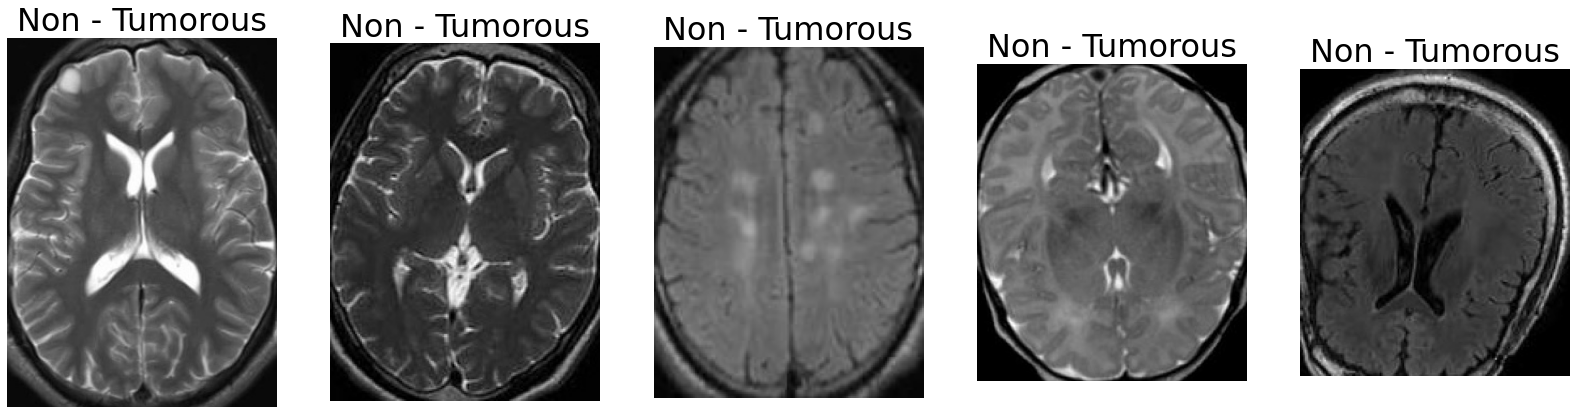

In [48]:
fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(infected_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Tumorous', fontsize=32)
plt.show()


fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(healthy_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Non - Tumorous', fontsize=32)
plt.show()

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(240,240),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(240, 240),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 1445 images belonging to 2 classes.
Found 310 images belonging to 2 classes.


In [50]:
class_labels, class_names

({'non-tumorous': 0, 'tumorous': 1}, {0: 'non-tumorous', 1: 'tumorous'})

## Model Building

### Transfer Learning - VGG19 CNN Architecture

In [66]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (240,240,3),
                   include_top = False, 
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False
    
x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'models/model.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
sgd = SGD(learning_rate=.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [67]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=10,
                          epochs=20,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.4938
Epoch 1: val_loss improved from inf to 0.70922, saving model to models/model.h5
10/10 [==============================] - 12s 1s/step - loss: 0.7457 - accuracy: 0.4938 - val_loss: 0.7092 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.5017
Epoch 2: val_loss did not improve from 0.70922
10/10 [==============================] - 7s 695ms/step - loss: 0.7124 - accuracy: 0.5017 - val_loss: 0.7276 - val_accuracy: 0.4935 - lr: 1.0000e-04
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.7287 - accuracy: 0.5375
Epoch 3: val_loss improved from 0.70922 to 0.69542, saving model to models/model.h5
10/10 [==============================] - 12s 1s/step - loss: 0.7287 - accuracy: 0.5375 - val_loss: 0.6954 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss:

#### Evaluation Metrics

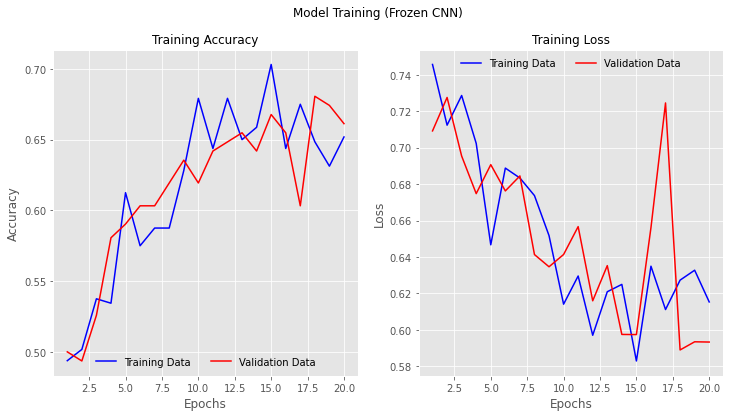

In [68]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [70]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='model_weights/vgg19_model_01.h5', overwrite=True)

In [71]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(240, 240),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 310 images belonging to 2 classes.


In [72]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01.h5')

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

310/310 [==============================] - 5s 17ms/step - loss: 0.5527 - accuracy: 0.7129
Validation loss:     0.5933
Validation accuracy: 0.6613
Test loss:           0.5527
Test accuracy:       0.7129


In [73]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

310/310 [==============================] - 5s 14ms/step


In [74]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01, 
                            target_names=['tumorous', 'non-tumorous']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01), 
                        index=['tumorous', 'non-tumorous'], 
                        columns=['tumorous', 'non-tumorous'])

              precision    recall  f1-score   support

    tumorous       0.67      0.76      0.72       147
non-tumorous       0.76      0.67      0.71       163

    accuracy                           0.71       310
   macro avg       0.72      0.72      0.71       310
weighted avg       0.72      0.71      0.71       310



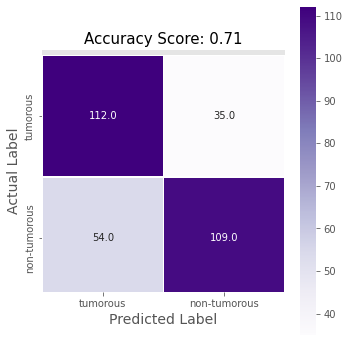

In [75]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.savefig("outputs/confusion_matrix1.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.tight_layout()

In [76]:
print('F1 Score: %.4f' % f1_score(test_generator.classes, vgg_pred_labels_01))

F1 Score: 0.7101


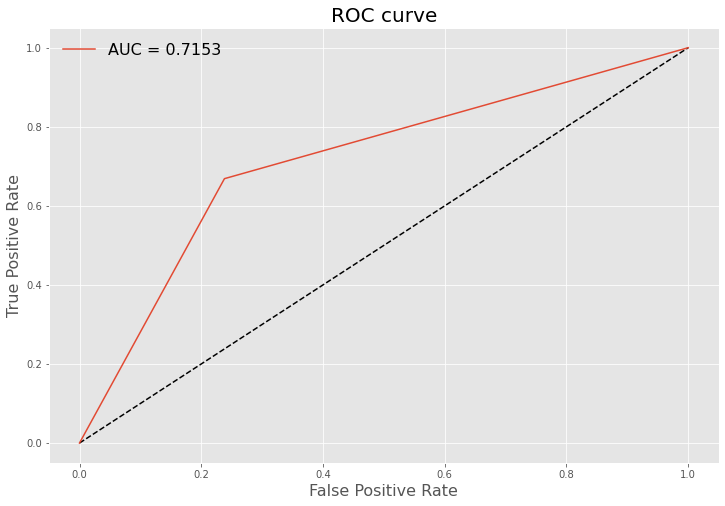

In [77]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

### Incremental unfreezing and fine-tuning

In [81]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [82]:
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [83]:
history_02 = model_02.fit(train_generator, 
                          steps_per_epoch=10, 
                          epochs=10, 
                          callbacks = [es, cp, lrr], 
                          validation_data = valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.9887 - accuracy: 0.5750
Epoch 1: val_loss did not improve from 0.58891
10/10 [==============================] - 9s 811ms/step - loss: 0.9887 - accuracy: 0.5750 - val_loss: 0.7709 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.6177
Epoch 2: val_loss did not improve from 0.58891
10/10 [==============================] - 7s 745ms/step - loss: 0.6309 - accuracy: 0.6177 - val_loss: 0.6715 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6375
Epoch 3: val_loss did not improve from 0.58891
10/10 [==============================] - 8s 787ms/step - loss: 0.6499 - accuracy: 0.6375 - val_loss: 0.6251 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.6348
Epoch 4: val_loss improved from 0.58891 to 0.58352,

In [84]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.h5', overwrite=True)

#### Evaluation Metrics

310/310 [==============================] - 5s 16ms/step - loss: 0.4802 - accuracy: 0.7613
Validation loss:     0.47262707352638245
Validation accuracy: 0.7354838848114014
Test loss:           0.48020148277282715
Test accuracy:       0.7612903118133545
310/310 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

    tumorous       0.90      0.56      0.69       147
non-tumorous       0.70      0.94      0.81       163

    accuracy                           0.76       310
   macro avg       0.80      0.75      0.75       310
weighted avg       0.80      0.76      0.75       310



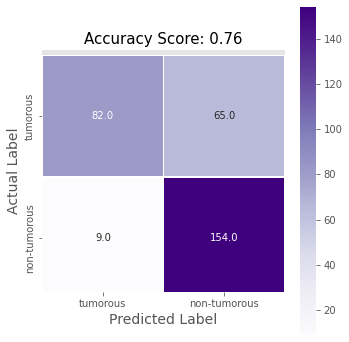

In [85]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.h5')

# Evaluate the model on the hold out validation and test datasets
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02, 
                            target_names=['tumorous', 'non-tumorous']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02), 
                        index=['tumorous', 'non-tumorous'], 
                        columns=['tumorous', 'non-tumorous'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.savefig("outputs/confusion_matrix2.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.tight_layout()

In [86]:
print('F1 Score: %.4f' % f1_score(test_generator.classes, vgg_pred_labels_02))

F1 Score: 0.8063


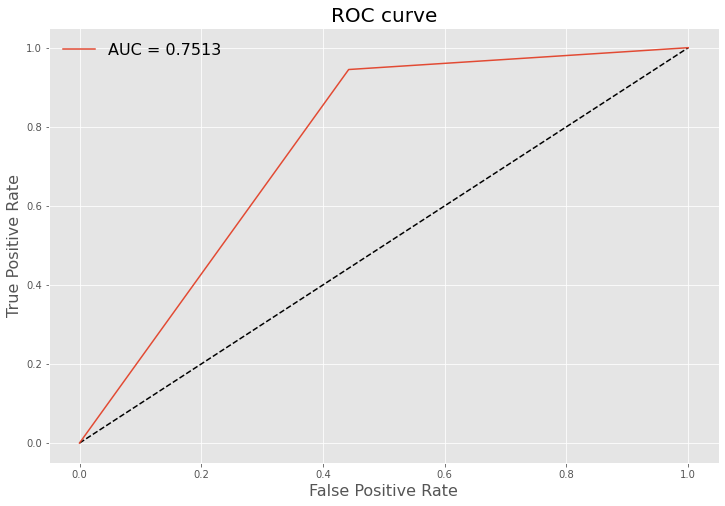

In [87]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

### Unfreezing and fine-tuning the entire network

In [90]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(240,240,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=40,
                          epochs=30,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.7845
Epoch 1: val_loss improved from 0.45372 to 0.37018, saving model to models/model.h5
40/40 [==============================] - 36s 847ms/step - loss: 0.4570 - accuracy: 0.7845 - val_loss: 0.3702 - val_accuracy: 0.8355 - lr: 1.0000e-04
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8250
Epoch 2: val_loss improved from 0.37018 to 0.25338, saving model to models/model.h5
40/40 [==============================] - 33s 830ms/step - loss: 0.4058 - accuracy: 0.8250 - val_loss: 0.2534 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8292
Epoch 3: val_loss did not improve from 0.25338
40/40 [==============================] - 29s 715ms/step - loss: 0.3894 - accuracy: 0.8292 - val_loss: 0.2602 - val_accuracy: 0.8871 - lr: 1.0000e-04
Epoch 4/30
40/40 [==============================] - ETA:

#### Evaluation Metrics

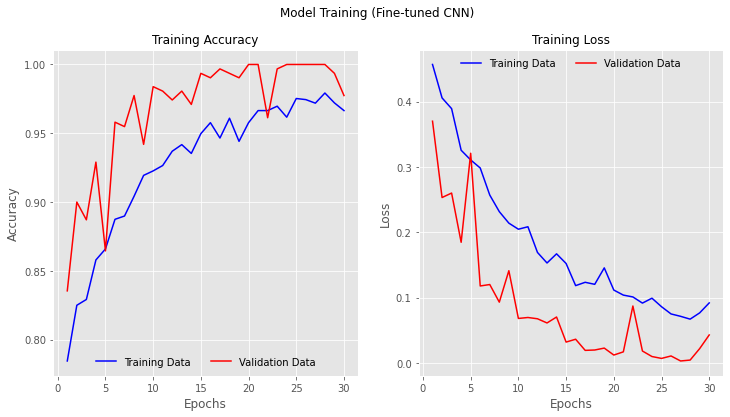

In [108]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("outputs/training_finetunedcnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [93]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.h5', overwrite=True)

310/310 [==============================] - 5s 17ms/step - loss: 0.0553 - accuracy: 0.9806
Validation loss     :0.0430
Validation accuracy :0.9774
Test loss           :0.0553
Test accuracy       :0.9806
310/310 [==============================] - 5s 14ms/step
              precision    recall  f1-score   support

    tumorous       0.96      1.00      0.98       147
non-tumorous       1.00      0.96      0.98       163

    accuracy                           0.98       310
   macro avg       0.98      0.98      0.98       310
weighted avg       0.98      0.98      0.98       310



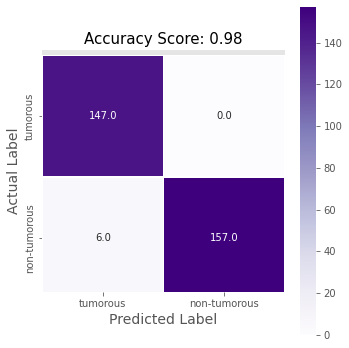

In [94]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.h5')

# Evaluate the model on the hold out validation and test datasets
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)

# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03, 
                            target_names=['tumorous', 'non-tumorous']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03), 
                        index=['tumorous', 'non-tumorous'], 
                        columns=['tumorous', 'non-tumorous'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.savefig("outputs/confusion_matrix3.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.tight_layout()

In [95]:
print('F1 Score: %.4f' % f1_score(test_generator.classes, vgg_pred_labels_03))

F1 Score: 0.9812


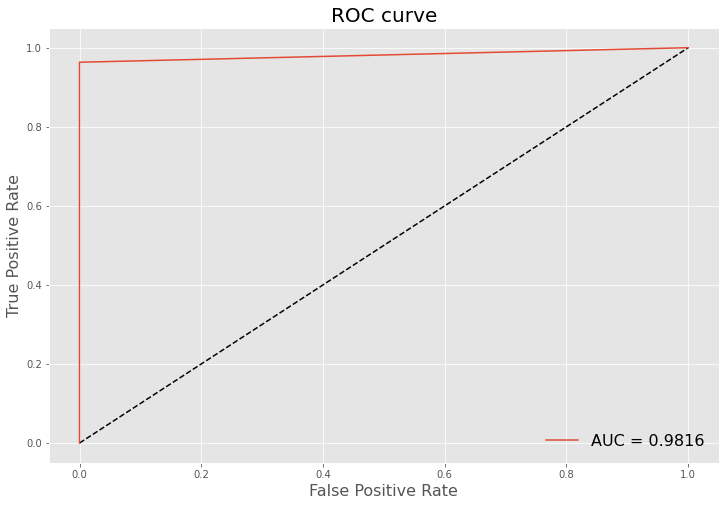

In [96]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

## Evaluation Plots

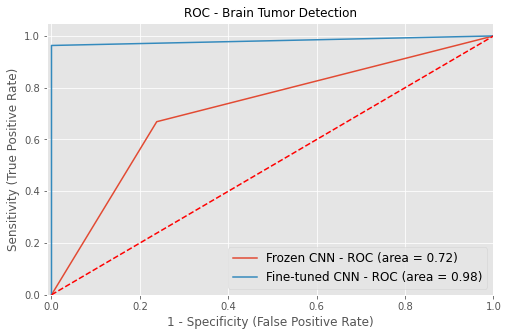

In [97]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
    'roc': vgg_pred_labels_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
    'roc': vgg_pred_labels_03,
}
]
for m in models:
    model = m['model']  
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, m['roc'])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 
             label='%s - ROC (area = %0.2f)' % (m['label'], area_under_curve))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Brain Tumor Detection', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("outputs/roc.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

[71.29, 98.06]
[71.53, 98.16]
[71.01, 98.12]


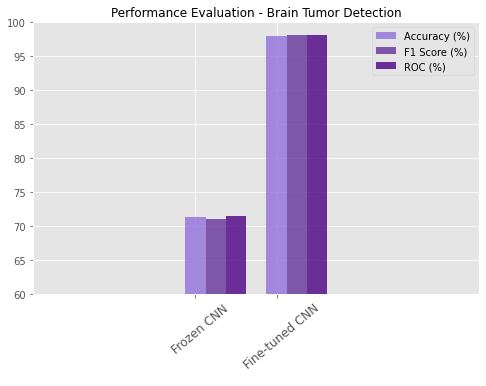

In [98]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

means_roc = [71.53, 98.16]
means_accuracy = [71.29, 98.06]
means_f1score = [71.01, 98.12]

print(means_accuracy)
print(means_roc)
print(means_f1score)

# data to plot
n_groups = 2
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)
means_f1score = tuple(means_f1score)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity, 
color='mediumpurple',
label='Accuracy (%)')

rects2 = plt.bar(index + bar_width, means_f1score, bar_width,
alpha=opacity, 
color='rebeccapurple',
label='F1 Score (%)')

rects3 = plt.bar(index + bar_width + bar_width, means_roc, bar_width,
alpha=opacity, 
color='indigo',
label='ROC (%)')

plt.xlim([-2, 3.5])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Brain Tumor Detection', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.savefig("outputs/PE.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

## Prediction results for 20 randomly selected images

In [101]:
test_images = [img for img in random.sample(infected_test_fpaths, 10)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 10)])

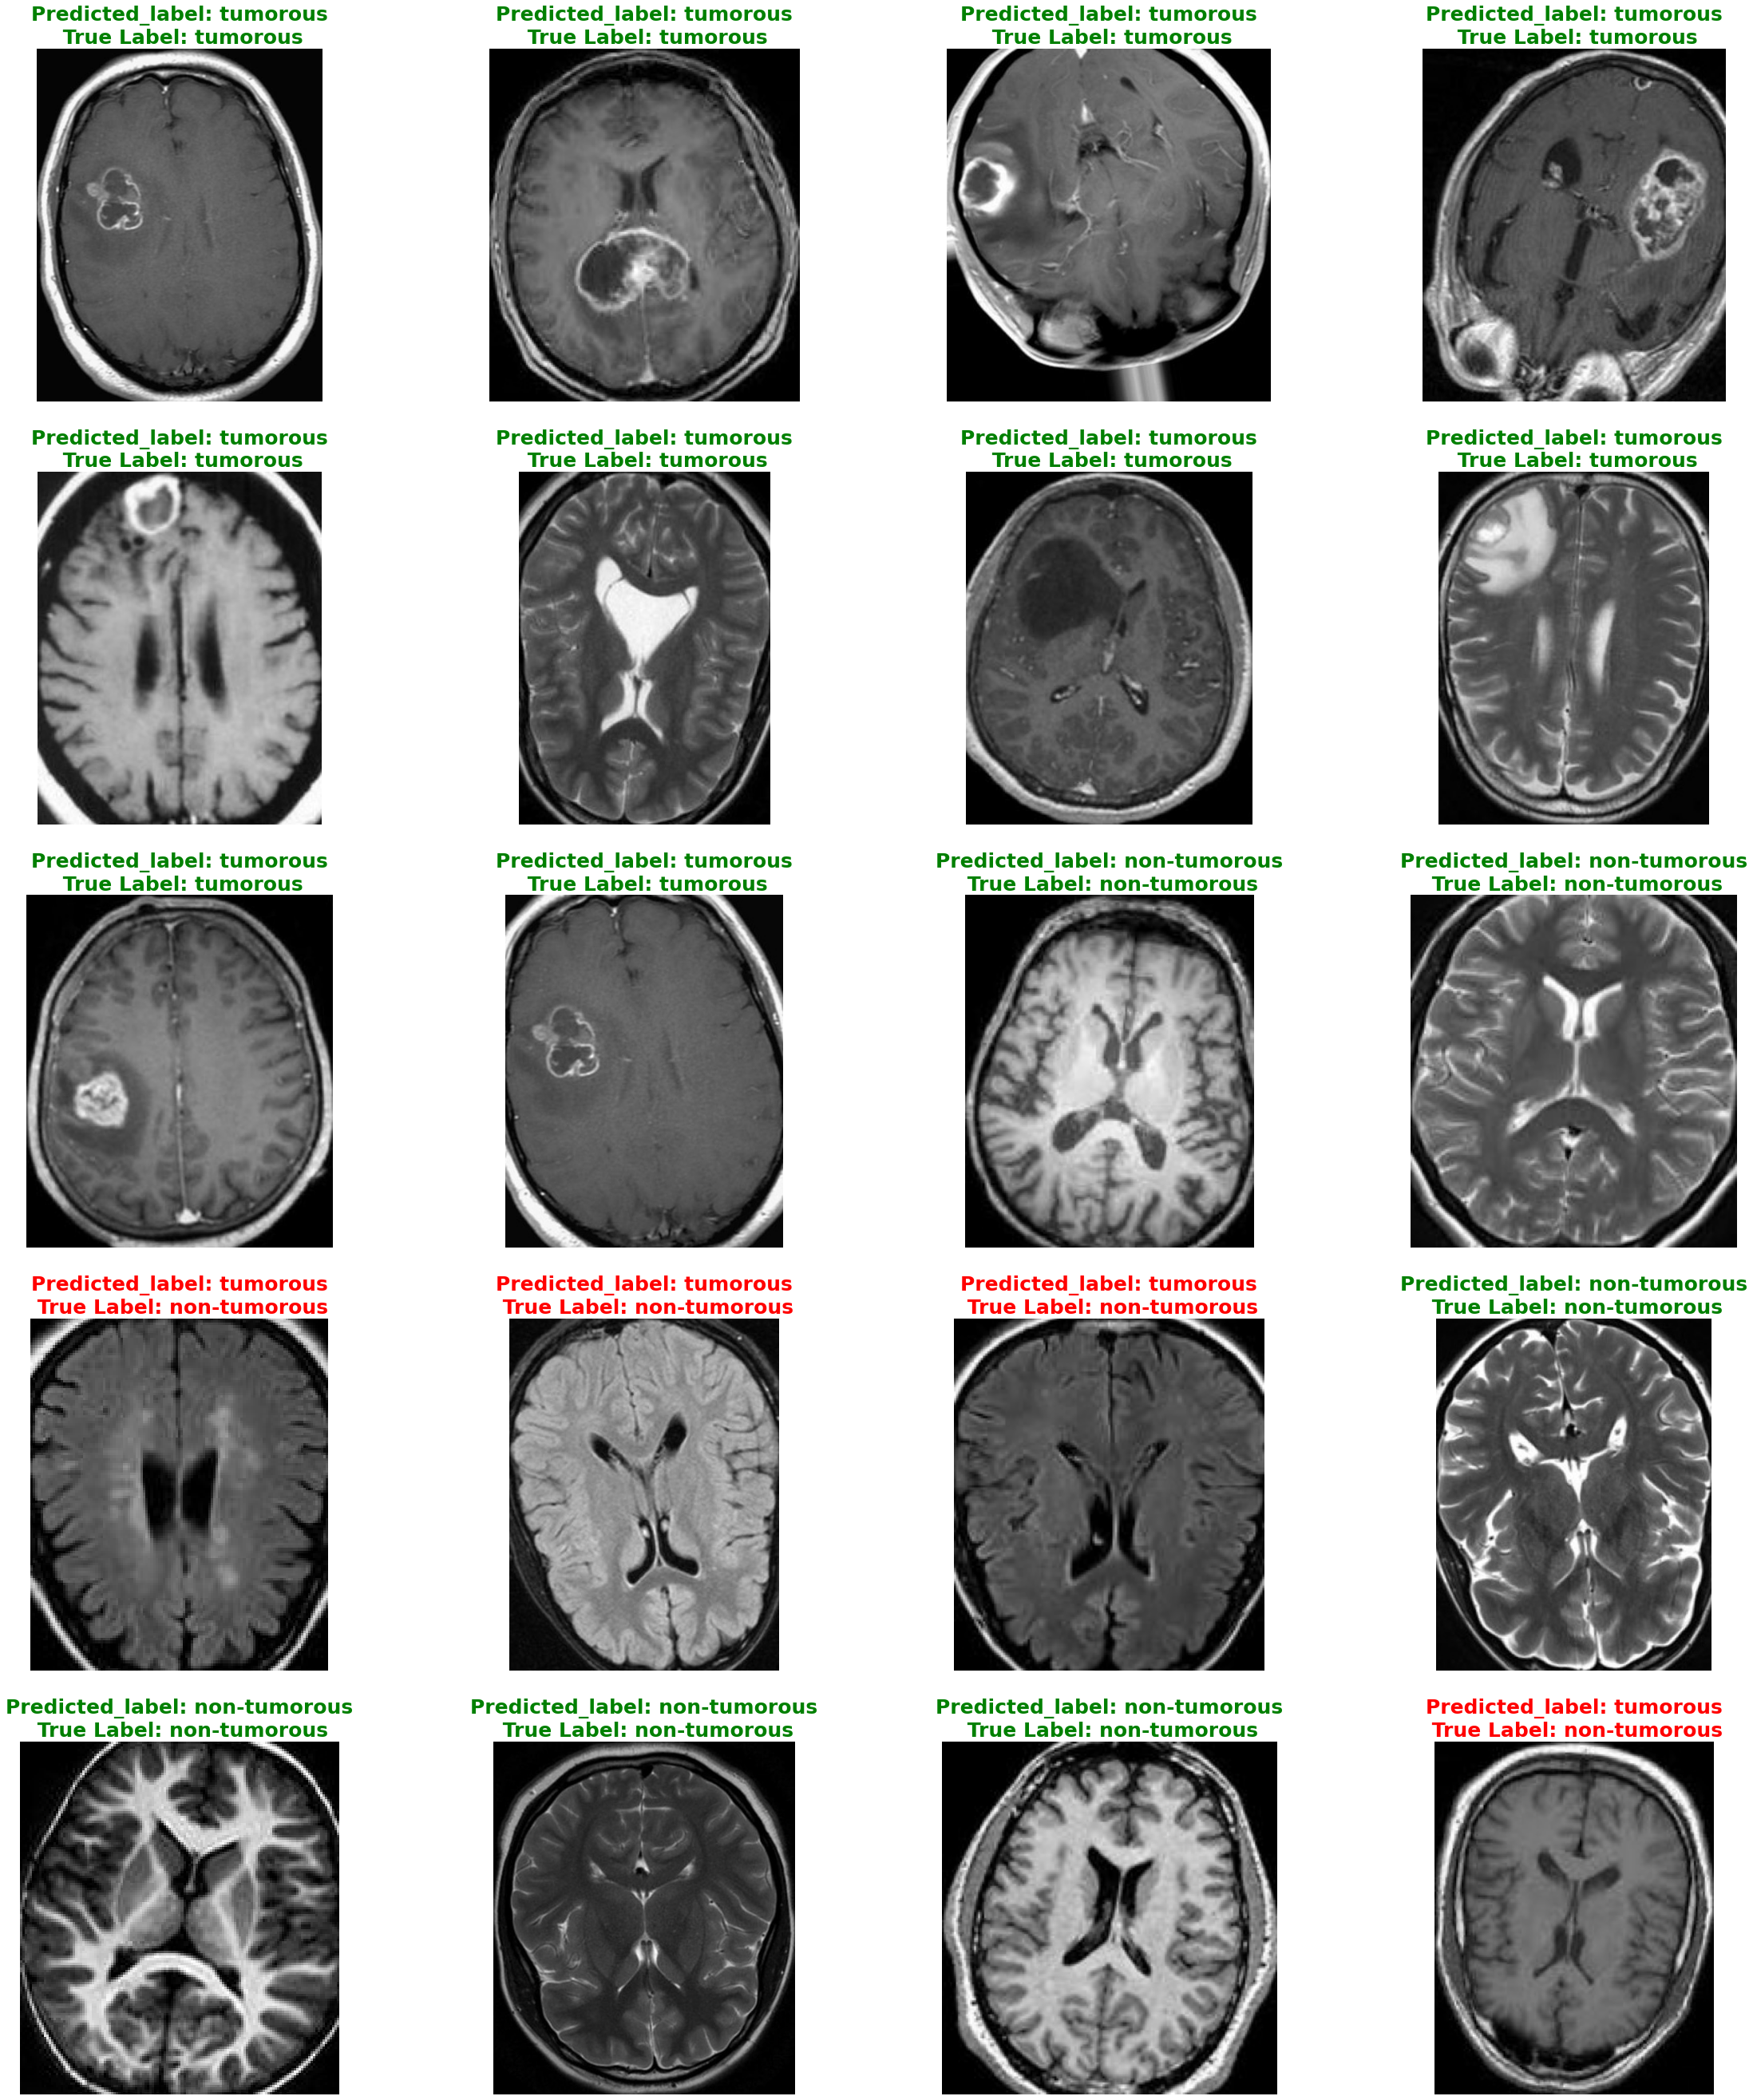

In [102]:
from keras.preprocessing.image import ImageDataGenerator
true_labels = []
predicted_labels = [] 
fig = plt.figure(figsize=(40,40))
columns=4
rows=5
plt.subplots_adjust(top = 0.9, bottom=0.01)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[2])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img)
    plt.axis('off')
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(240,240))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    if class_names[predicted_label] == true_labels[i-1]:
        plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], 
                                                                true_labels[i-1]), 
                                                                fontsize=25, 
                                                                color='green', 
                                                                fontweight='bold')
    else:
        plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], 
                                                                true_labels[i-1]), 
                                                                fontsize=25, 
                                                                color='red', 
                                                                fontweight='bold')
        
plt.savefig("outputs/predictions.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

### *~ Kanchi Tank*